In [1]:
# I want to try and apply what I've learnt to this data

# I'm going to do a factor analysis of the success characteristics

# If I can work out how!!

# As always, first import all the goodies

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline
from factor_analyzer import FactorAnalyzer


In [2]:
# get the indicators data
indicators=pd.read_csv("RHoMISmother_indicators.csv")

In [3]:
# and the raw data
codebook=pd.read_csv("raw data code book.csv")
raw=pd.read_csv("RHoMISmother_rawdata.csv",encoding = "ISO-8859-1", low_memory=False)

In [4]:
# looking for duds in the HFIAS data
# I coded these as missing values before, but actually I want to see what was done with them
raw['HHid']=raw['HouseholdID']
HFIAS_data=pd.merge(raw[['HHid','HFIAS_1','HFIAS_2','HFIAS_3','HFIAS_4','HFIAS_5','HFIAS_6','HFIAS_7','HFIAS_8',
                         'HFIAS_9']],indicators[['HHid','HFIAS_status']],on='HHid')


for k in range (9):
    col = HFIAS_data.columns[k+1]
    HFIAS_data[col+'incomplete']=np.where(pd.isnull(HFIAS_data[col]),1,0)

        
HFIAS_data['Number incomplete']=0
for k in range (9):
    col = HFIAS_data.columns[k+1]
    HFIAS_data['Number incomplete']+=HFIAS_data[col+'incomplete']


HFIAS_data.head()

,HHid,HFIAS_1,HFIAS_2,HFIAS_3,HFIAS_4,HFIAS_5,HFIAS_6,HFIAS_7,HFIAS_8,HFIAS_9,...,HFIAS_1incomplete,HFIAS_2incomplete,HFIAS_3incomplete,HFIAS_4incomplete,HFIAS_5incomplete,HFIAS_6incomplete,HFIAS_7incomplete,HFIAS_8incomplete,HFIAS_9incomplete,Number incomplete
0,1,NaN,NaN,NaN,weekly,weekly,weekly,never,never,never,...,1,1,1,0,0,0,0,0,0,3
1,2,NaN,NaN,NaN,NaN,NaN,NaN,monthly,weekly,weekly,...,1,1,1,1,1,1,0,0,0,6
2,3,NaN,monthly,monthly,never,never,never,never,never,never,...,1,0,0,0,0,0,0,0,0,1
3,4,NaN,NaN,NaN,NaN,NaN,NaN,monthly,monthly,monthly,...,1,1,1,1,1,1,0,0,0,6
4,6,NaN,monthly,never,monthly,never,never,never,never,never,...,1,0,0,0,0,0,0,0,0,1


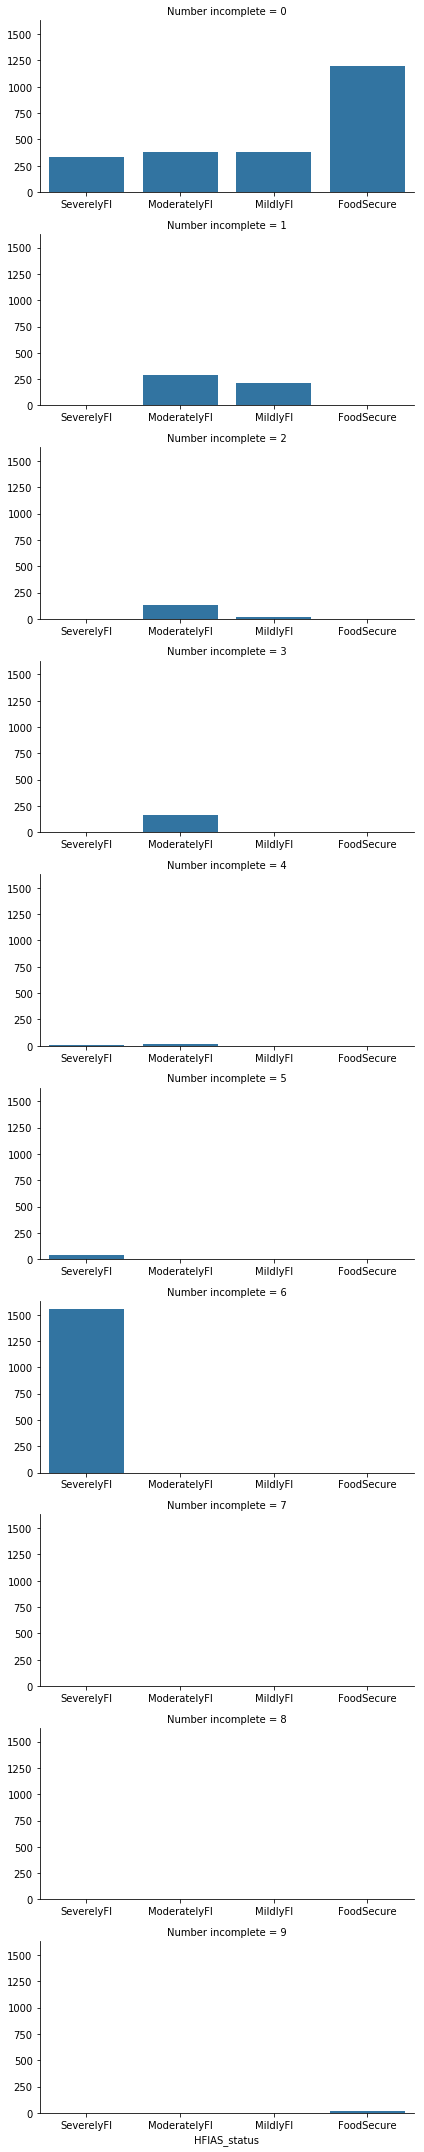

In [5]:
# Now let's compare the ones with lots of incompletes
HFIAS_data['HFIAS_status']=HFIAS_data['HFIAS_status'].astype('category')

sns.FacetGrid(HFIAS_data,row='Number incomplete', aspect=2).map(sns.countplot,'HFIAS_status', 
                                                      order = ['SeverelyFI', 'ModeratelyFI', 'MildlyFI','FoodSecure']
                                                               ).savefig("1CleansingHFIASincomplete")

In [6]:
# Funny how the statuses are clustered when there is more than one incomplete

# Are the same ones always missing?
# HFIAS_data.groupby(['Number incomplete']).mean()

In [7]:
# So in short, usually, yes; If just one is missing, it is almost always question 1.
# If two are missing, they are always the first 2
# this pattern pretty much follows

# So, for those with 6 incomplete, did they give the same answers for all the others?
# HFIAS_data[HFIAS_data['Number incomplete']==6][HFIAS_data.columns[1:11]].loc[0:40]
# even record 33 is severely FI. Maybe they haven't given enough information to say they're not severely FI?

In [8]:
# HFIAS_data[HFIAS_data['Number incomplete']==6][HFIAS_data['HFIAS_status']!='SeverelyFI'][HFIAS_data.columns[1:11]]

In [9]:
# And what's happened when all 9 are missing?

# HFIAS_data[HFIAS_data['Number incomplete']==9][HFIAS_data.columns[1:11]].head()

# I think that's wrong. Those people will have to not have a HFIAS status for now.

In [10]:
HFIAS_data['HFIAS_status']=np.where(HFIAS_data['Number incomplete']==9, np.nan, HFIAS_data['HFIAS_status'])

# HFIAS_data[HFIAS_data['Number incomplete']>=7][HFIAS_data.columns[[7,8,9,10,20]]][:10]

# That's done it!

In [11]:
# In conclusion, I don't think these are droppable any more.
#I think they are still based on more information than the information that I get from dropping them!

# Now I just want to recode HFIAS_status and then add it to the indicators dataframe

HFIAS_data['HFIAS_code']=HFIAS_data['HFIAS_status'].replace(to_replace = {'SeverelyFI':3, 
                                                                         'ModeratelyFI':2, 'MildlyFI':1, 'FoodSecure':0})

# HFIAS_data[['HFIAS_status','HFIAS_code']].loc[:10]
# seems to have worked

In [12]:
indicators = pd.merge(indicators, HFIAS_data[['HHid','HFIAS_code','Number incomplete']], on = 'HHid')

In [13]:
# create a new column for income_percap
# this will be a problem if there are households with 0 members
len(indicators[indicators['HHsizeMAE']==0])

36

In [14]:
len(indicators[indicators['HHsizemembers']==0])

15

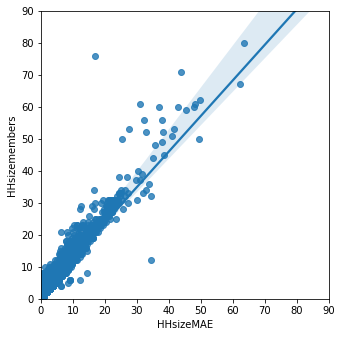

In [15]:
axes = plt.axes([0,0,1,1], xlim=(0,90), ylim=(0,90), aspect=1)
p=sns.regplot(data=indicators, x='HHsizeMAE',y= 'HHsizemembers', ax=axes)
p.figure.savefig("1CleansingHHsizescatter")

In [16]:
# Have NaN if you don't have any members - only 15 households.
indicators['dummy'] = np.where(indicators['HHsizeMAE']==0, indicators['HHsizemembers'], indicators['HHsizeMAE'])
indicators['Income per MAE'] = np.where (indicators['dummy']==0,np.nan, np.divide(indicators['total_income'], indicators['dummy']))
# indicators[['HHsizeMAE', 'HHsizemembers','dummy', 'total_income','Income per MAE' ]].head()

C:\Users\Clare\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Clare\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
# indicators[indicators['HHsizeMAE']==0][['HHsizeMAE', 'HHsizemembers','dummy', 'total_income','Income per MAE' ]].head()

In [18]:
# indicators[indicators['Income per MAE']==np.inf][['HHsizeMAE', 'HHsizemembers','dummy', 'total_income','Income per MAE' ]].head()

In [19]:
# make a new income percentile column
percentiles=np.zeros(10)
for i in range(9):
    j=np.divide(i+1,10)
    percentiles[i+1]=indicators['Income per MAE'].quantile (q=j, interpolation='linear')
print(percentiles)
indicators['Income/MAE decile']=0
for k in range(9):
    indicators['Income/MAE decile'] = np.where(indicators['Income per MAE']>percentiles[k+1],
                                               k+1, indicators['Income/MAE decile'])
#indicators['Income/MAE decile'] = np.where(indicators['HHsizemembers']==0, np.nan, indicators['Income/MAE decile'])
indicators[['Income per MAE','Income/MAE decile']][:10]

[  0.00000000e+00   1.89218432e-01   1.05003592e+01   2.58709179e+01
   5.14345659e+01   9.37712362e+01   1.56430367e+02   2.66220985e+02
   4.76361238e+02   1.09312727e+03]


,Income per MAE,Income/MAE decile
0,0.000000,0
1,15.479876,2
2,1861.558219,9
3,23.712096,2
4,101.130597,5
5,292.883895,7
6,247.872024,6
7,16.187050,2
8,0.000000,0
9,209.772390,6


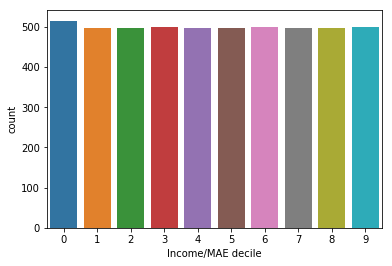

In [20]:
sns.countplot(indicators['Income/MAE decile'])
# 0 is bigger because of the households with 0 income


In [21]:
# just checking it worked...
#for k in range(10):
 #   print(k + 1)
  #  print (percentiles[k])
   # print( np.divide(len(indicators[indicators['Income per MAE']<=percentiles[k]]),len(indicators)-15))

In [22]:
# I'd also like to do income decile by country and by region
def income_decile(data, condition, name):
    D=data[condition]
    percentiles=np.zeros(10)
    D['temp']=0
    for i in range(9):
        j=np.divide(i+1,10)
        percentiles[i+1]=D['Income per MAE'].quantile (q=j, interpolation='linear')
    print(percentiles)
    for k in range(9):
    #    print(D['temp'].head())
        D['temp']=np.where(D['Income per MAE']>percentiles[k+1], 
                                             k+1, D['temp'])
    #    indicators[name] = np.where(condition, indicators[name], indicators[name])
    output = pd.merge(data, D[['HHid','temp']], on = 'HHid', how = 'outer')
#    print(output.head())
    output[name]=np.where(np.isnan(output['temp']),output[name],output['temp'])
    output.drop('temp',axis=1, inplace=True)
    return output

In [23]:
indicators['dummy']=np.nan
indir=income_decile(indicators,(indicators['HHid'])>2, 'dummy')

C:\Users\Clare\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\Clare\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


[  0.00000000e+00   1.98138010e-01   1.05238918e+01   2.59307568e+01
   5.14943813e+01   9.40479425e+01   1.56555001e+02   2.66869350e+02
   4.76495413e+02   1.09381935e+03]


In [24]:
indir['dummy'].unique()

array([ nan,   9.,   2.,   5.,   7.,   6.,   0.,   3.,   4.,   8.,   1.])

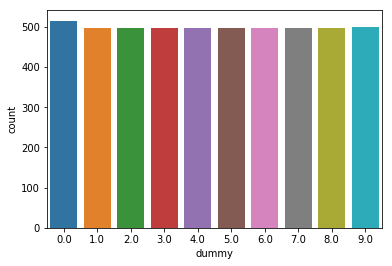

In [25]:
sns.countplot(indir['dummy'])
# it works!

In [26]:
indicators['Income/MAE for country'] = 12
for c in indicators['Country'].unique():
    print(c)
    indicators = income_decile(indicators,indicators['Country']==c, 'Income/MAE for country')

Kenya
[    0.            10.1708736     34.58188511    71.98757764   120.45102567
   183.06306306   277.76422153   436.51475034   746.49409438  1418.26780435]


C:\Users\Clare\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\Clare\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


Ethiopia
[    0.             0.             9.33205497    58.7138202    119.67117988
   194.10315109   312.44357143   498.16327307  1024.88023823  2197.2967065 ]
Tanzania
[    0.            10.93482906    35.31768964    72.15422783   111.61221474
   173.14503057   241.60020313   351.77153159   544.87180983  1107.03979372]
Zambia
[   0.            0.            0.            0.            0.
    6.17283951   17.21170396   35.78768199   70.58566434  155.27950311]
Mali
[   0.            0.75545972   14.43774737   23.77396682   36.78952584
   51.88624342   79.53975216  111.10513864  170.04195968  398.55658228]
Cambodia
[    0.            84.22172452   188.04878049   273.21140553   409.006734
   565.97222229   701.89571275   933.79948915  1222.2324696   1936.77059497]
Vietnam
[    0.             4.04887553   274.62121211   450.18939397   667.93046268
   914.77544899  1235.29411765  1515.31424686  2252.52984507  3584.77102972]
DRC
[   0.            2.72987852    6.35132876   13.24873872   20

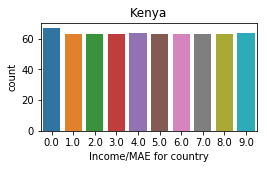

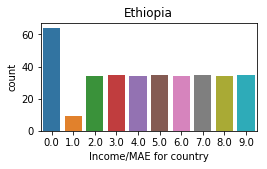

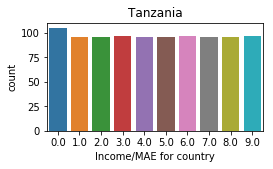

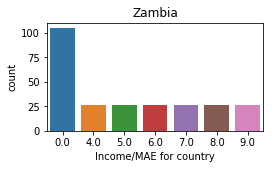

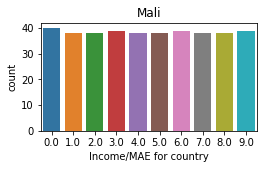

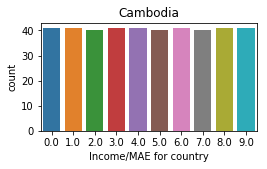

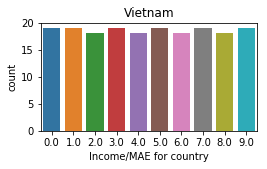

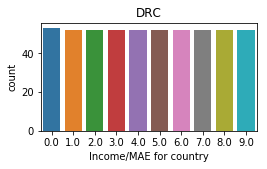

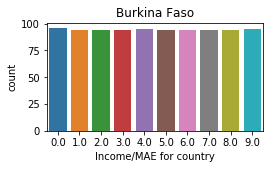

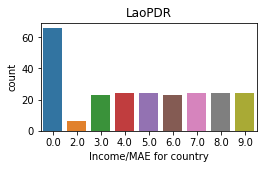

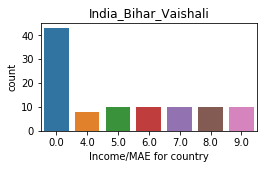

In [27]:
for c in indicators['Country'].unique():
    fig = plt.figure(figsize=(3,1.5))
    axes = fig.add_axes([0,0,1,1])
    axes.set_title(c)
    sns.countplot(indicators[indicators['Country']==c]['Income/MAE for country'],ax=axes ).figure.savefig("1CleansingIncDec"+c)
# So it has worked!!

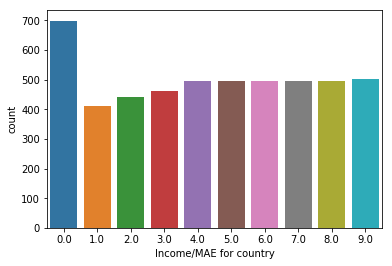

In [28]:
sns.countplot(indicators['Income/MAE for country'])
# this does make sense, because in lots of countries, the bottom few deciles are all 0
# meaning there is a jump
# so more than 10% of people are on 0 money, and so the first decile appears 'empty'

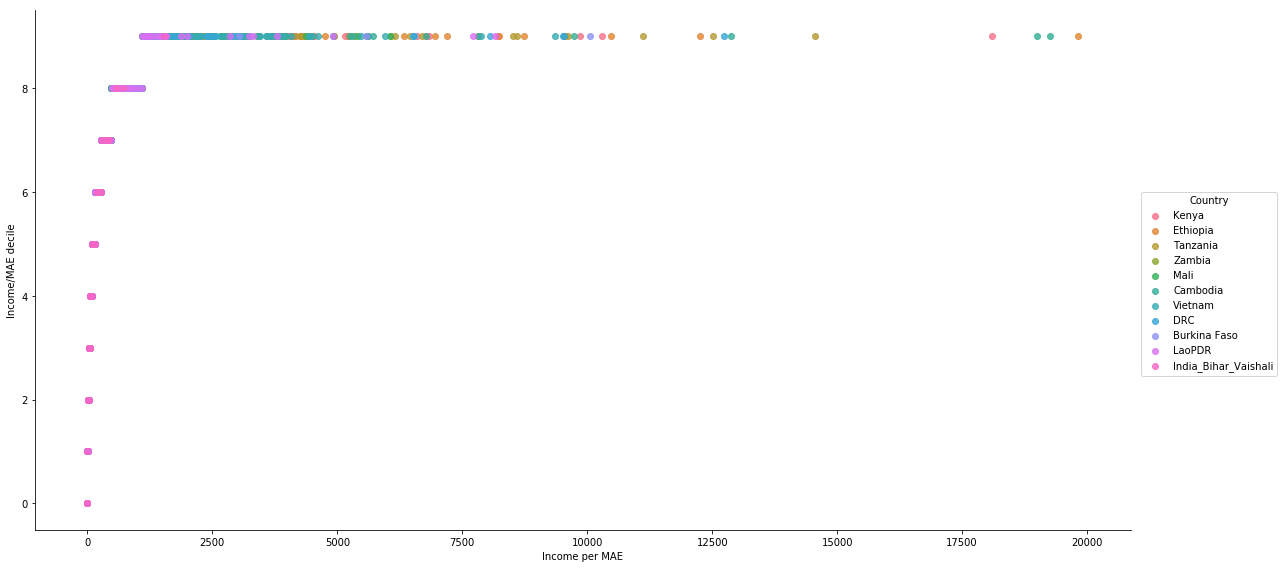

In [29]:
sns.lmplot(data=indicators[indicators['Income per MAE']<2e4], x='Income per MAE', y='Income/MAE decile', 
           hue = 'Country', fit_reg=False, size=8, aspect = 2).savefig("1CleansingIncomeDec by country")

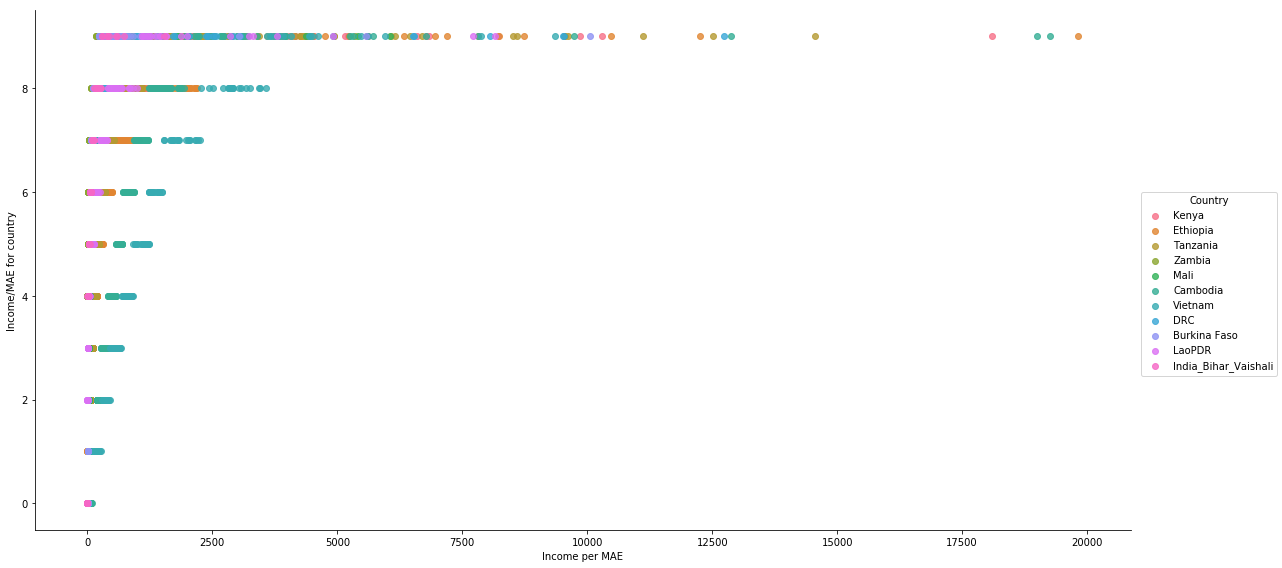

In [30]:
sns.lmplot(data=indicators[indicators['Income per MAE']<2e4], x='Income per MAE', y='Income/MAE for country', 
           hue = 'Country', fit_reg=False, size=8, aspect = 2).savefig("1CleansingIncomeDecCountry by country")

In [31]:
indicators.to_csv("1CleansingOutput")

In [32]:
# So return now to look at the indicators of success
indicators_success=indicators[['NrofMonthsFoodInsecure','score_PPI','HFIAS_code','score_HDDSBadSeason', 'score_HDDSGoodSeason',
                               'Income/MAE decile', 'Income/MAE for country']]

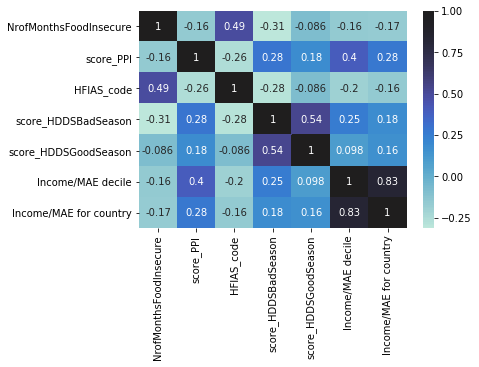

In [33]:
sns.heatmap(indicators_success.corr(method = 'spearman'),annot=True, center=1)

In [34]:
# because the PCA doesn't seem to have worked very well
np.linalg.det(indicators_success.corr())

0.09511938127964091

In [35]:
import statsmodels.multivariate.pca as smp

In [36]:
pca = smp.PCA(indicators_success, method = 'nipals', missing='drop-row', ncomp=6)

# I didn't like this, thought the eigenvalues were unmanageable and was concerned that I couldn't rotate it

In [37]:
pca.eigenvals

0    8777.620717
1    4495.480269
2    3749.305370
3    2323.432074
4    1754.656980
5    1211.068374
Name: eigenvals, dtype: float64

In [38]:
pca.loadings

,comp_0,comp_1,comp_2,comp_3,comp_4,comp_5
NrofMonthsFoodInsecure,0.272582,0.388615,0.528433,0.099688,-0.676579,0.141632
score_PPI,-0.371404,0.034509,0.169253,0.897266,0.136814,-0.040346
HFIAS_code,0.302657,0.357495,0.492838,-0.086160,0.720676,0.104325
score_HDDSBadSeason,-0.414129,-0.366907,0.316075,-0.198443,0.011128,0.731644
score_HDDSGoodSeason,-0.332390,-0.299464,0.571293,-0.247430,-0.041044,-0.633797
Income/MAE decile,-0.467120,0.493028,-0.063144,-0.123813,-0.041260,0.111666
Income/MAE for country,-0.442685,0.502602,-0.137685,-0.248239,0.025276,-0.134007


In [39]:
def scree(fa):
    eigs = fa.get_eigenvalues()[0]
    index = np.arange(len(eigs))
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.plot(index, eigs, 'bo-')
    ax.set_title('Scree Plot')

,Factor1,Factor2,Factor3
NrofMonthsFoodInsecure,-0.062488,-0.097003,0.695844
score_PPI,0.312109,0.325898,-0.149400
HFIAS_code,-0.110170,-0.137372,0.626046
score_HDDSBadSeason,0.130445,0.761255,-0.289846
score_HDDSGoodSeason,0.080219,0.760055,-0.021113
Income/MAE decile,0.989114,0.159263,-0.070794
Income/MAE for country,0.865567,0.091058,-0.121654


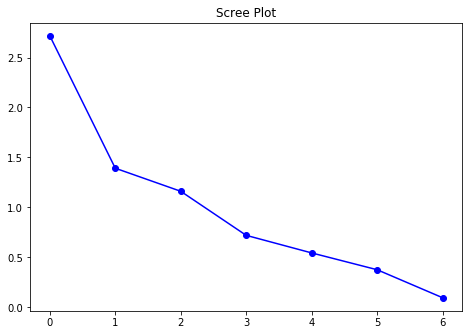

In [40]:
fa = FactorAnalyzer()
fa.analyze(indicators_success, impute='drop', rotation='varimax')
scree(fa)
fa.loadings

In [41]:
fa.get_eigenvalues()

(   Original_Eigenvalues
 0              2.411629
 1              1.113009
 2              0.675408
 3              0.064556
 4              0.020045
 5             -0.025612
 6             -0.066518,    Common_Factor_Eigenvalues
 0                   2.411629
 1                   1.113009
 2                   0.675408
 3                   0.064556
 4                   0.020045
 5                  -0.025612
 6                  -0.066518)

C:\Users\Clare\Anaconda3\lib\site-packages\factor_analyzer\factor_analyzer.py:770: UserWarning: No rotation will be performed when the number of factors equals 1.
  warnings.warn('No rotation will be performed when '


   Original_Eigenvalues
0              2.106013
1              0.760320
2              0.316149
3             -0.014948
4             -0.293716
5             -0.341327
6             -0.426479
   Original_Eigenvalues
0              2.379962
1              1.073669
2              0.402866
3              0.037835
4              0.004332
5             -0.137177
6             -0.310683
   Original_Eigenvalues
0              2.411629
1              1.113009
2              0.675408
3              0.064556
4              0.020045
5             -0.025612
6             -0.066518
   Original_Eigenvalues
0              2.475726
1              1.224620
2              0.812267
3              0.192957
4              0.010559
5             -0.003639
6             -0.007495
   Original_Eigenvalues
0              2.480883
1              1.183408
2              0.707076
3              0.154338
4              0.084189
5              0.000006
6             -0.000007
   Original_Eigenvalues
0          2.479

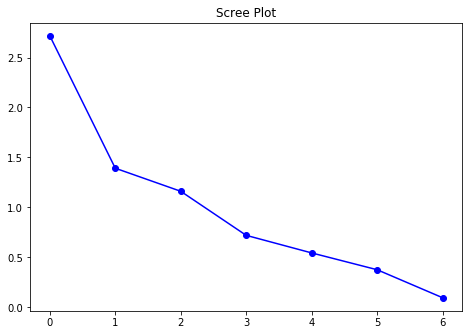

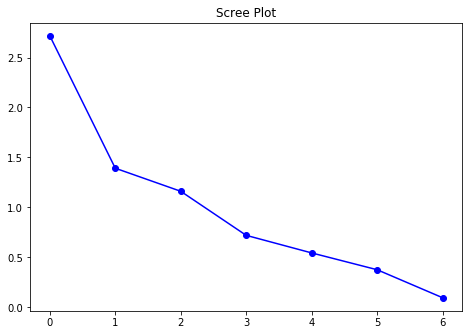

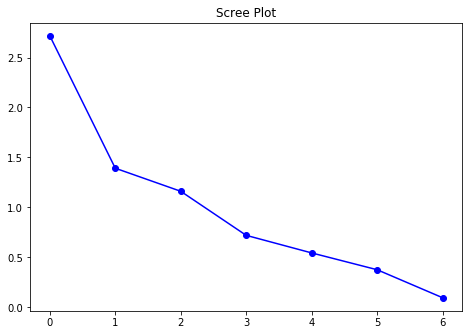

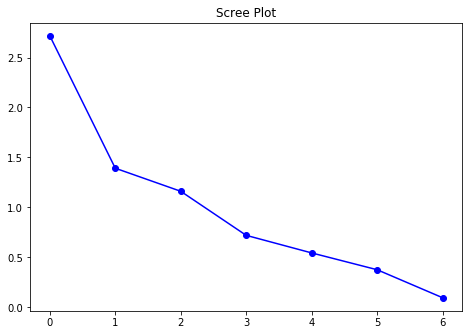

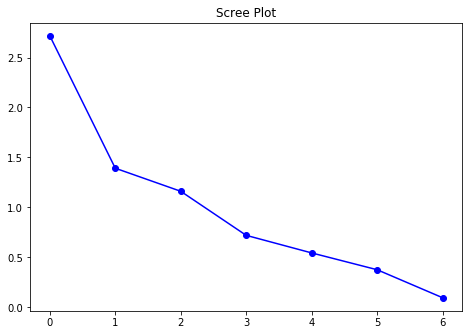

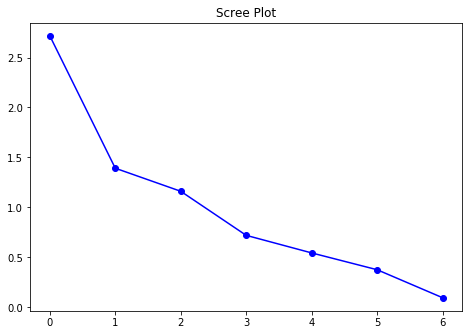

In [42]:
for k in range(6):
    fa = FactorAnalyzer()
    fa.analyze(indicators_success, impute='drop', n_factors =k+1, rotation='varimax')
    scree(fa)
    print(fa.get_eigenvalues()[0])
    
    # highly suspect as the eigenvalues depend on the number of factors being extracted

C:\Users\Clare\Anaconda3\lib\site-packages\factor_analyzer\factor_analyzer.py:770: UserWarning: No rotation will be performed when the number of factors equals 1.
  warnings.warn('No rotation will be performed when '


   Original_Eigenvalues
0              2.106013
1              0.760320
2              0.316149
3             -0.014948
4             -0.293716
5             -0.341327
6             -0.426479
   Original_Eigenvalues
0              2.434147
1              1.152868
2              0.409797
3              0.071273
4              0.031442
5             -0.122763
6             -0.318638
   Original_Eigenvalues
0              2.465225
1              1.174244
2              0.737523
3              0.128111
4              0.021859
5              0.001823
6             -0.083497
   Original_Eigenvalues
0              2.453491
1              1.247570
2              0.879758
3              0.196215
4             -0.002836
5             -0.069011
6             -0.144302
   Original_Eigenvalues
0              2.431843
1              1.141996
2              0.688554
3              0.128937
4             -0.000819
5             -0.018389
6             -0.084704
   Original_Eigenvalues
0              2

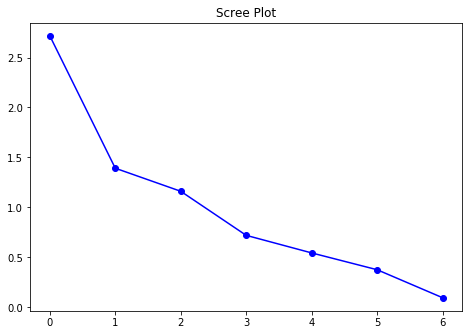

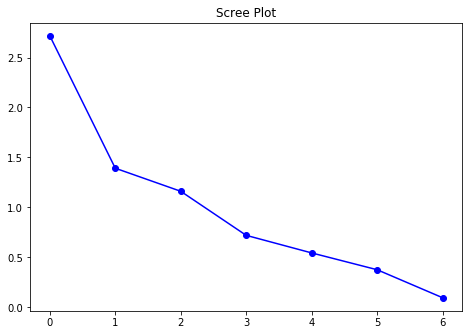

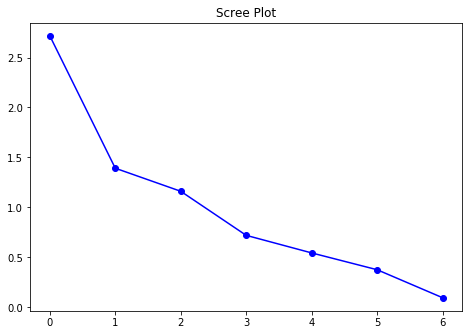

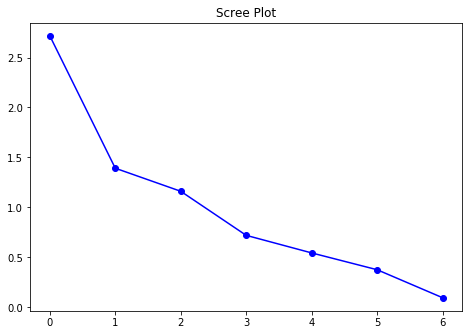

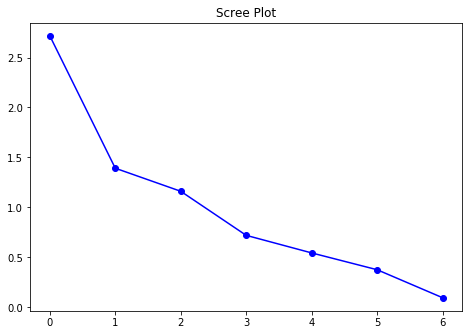

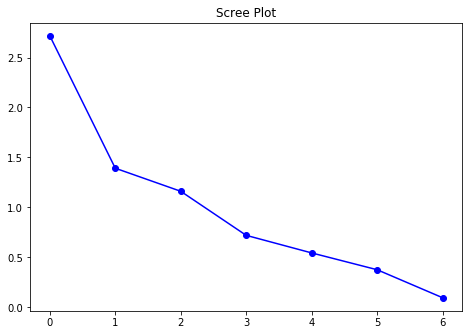

In [43]:
for k in range(6):
    fa = FactorAnalyzer()
    fa.analyze(indicators_success, impute='drop', n_factors =k+1)
    scree(fa)
    print(fa.get_eigenvalues()[0])

In [44]:
p=np.linalg.eig(indicators_success.corr())
p
# these are what I had been expecting the eigenvales to be!

(array([ 2.62601489,  1.38293966,  1.16228555,  0.14098241,  0.76765232,
         0.51867784,  0.40144732]),
 array([[ 0.29287238, -0.34853282, -0.5175719 , -0.06013655,  0.31789193,
         -0.64411011, -0.07294149],
        [-0.3785393 , -0.04902823, -0.03935042, -0.10426851,  0.85594502,
          0.30334267,  0.13124484],
        [ 0.32797311, -0.31507125, -0.51307806,  0.00259936, -0.11491205,
          0.6955046 , -0.18159423],
        [-0.40946584,  0.39254464, -0.32355545, -0.16440487, -0.05680655,
         -0.06817202, -0.73393115],
        [-0.29513007,  0.35144329, -0.60201017,  0.1652127 , -0.20149599,
         -0.02329757,  0.59877455],
        [-0.46592748, -0.49556332,  0.01434598,  0.70622212, -0.10429774,
         -0.05492114, -0.15645681],
        [-0.43762421, -0.5036512 , -0.00340615, -0.65759489, -0.31367568,
         -0.03423754,  0.15104051]]))

In [45]:
from numpy import eye, asarray, dot, sum, diag
from numpy.linalg import svd
# ... from wikipedia or something...
def varimax(Phi, gamma = 1.0, q = 20, tol = 1e-6):
    p,k = Phi.shape
    R = eye(k)
    d=0
    for i in xrange(q):
        d_old = d
        Lambda = dot(Phi, R)
        u,s,vh = svd(dot(Phi.T,asarray(Lambda)**3 - (gamma/p) * dot(Lambda, diag(diag(dot(Lambda.T,Lambda))))))
        R = dot(u,vh)
        d = sum(s)
        if d_old!=0 and d/d_old < 1 + tol: break
    return dot(Phi, R)

In [46]:
p[1]

array([[ 0.29287238, -0.34853282, -0.5175719 , -0.06013655,  0.31789193,
        -0.64411011, -0.07294149],
       [-0.3785393 , -0.04902823, -0.03935042, -0.10426851,  0.85594502,
         0.30334267,  0.13124484],
       [ 0.32797311, -0.31507125, -0.51307806,  0.00259936, -0.11491205,
         0.6955046 , -0.18159423],
       [-0.40946584,  0.39254464, -0.32355545, -0.16440487, -0.05680655,
        -0.06817202, -0.73393115],
       [-0.29513007,  0.35144329, -0.60201017,  0.1652127 , -0.20149599,
        -0.02329757,  0.59877455],
       [-0.46592748, -0.49556332,  0.01434598,  0.70622212, -0.10429774,
        -0.05492114, -0.15645681],
       [-0.43762421, -0.5036512 , -0.00340615, -0.65759489, -0.31367568,
        -0.03423754,  0.15104051]])

In [47]:
import sklearn.decomposition as skd

In [48]:
pca = skd.PCA(6)

In [49]:
factorable = indicators_success.dropna(0, 'any')

In [50]:
factorable.head()

,NrofMonthsFoodInsecure,score_PPI,HFIAS_code,score_HDDSBadSeason,score_HDDSGoodSeason,Income/MAE decile,Income/MAE for country
0,5.0,49.0,2.0,4.0,6.0,0,0.0
1,7.0,19.0,3.0,3.0,7.0,2,1.0
2,4.0,55.0,1.0,7.0,7.0,9,9.0
3,4.0,51.0,3.0,4.0,6.0,2,1.0
4,2.0,43.0,1.0,3.0,7.0,5,3.0


In [51]:
for i in factorable.columns:
    a=(np.std(factorable[i]))*(np.std(factorable[i]))
    b=(np.mean(factorable[i]))
    factorable[i] = np.divide(factorable[i]-b,a)
factorable.head()
# normmalised version with nulls dropped


C:\Users\Clare\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,NrofMonthsFoodInsecure,score_PPI,HFIAS_code,score_HDDSBadSeason,score_HDDSGoodSeason,Income/MAE decile,Income/MAE for country
0,0.718359,0.018835,0.127040,-0.029072,-0.017921,-0.529543,-0.482719
1,1.204691,-0.067875,0.759498,-0.165400,0.163024,-0.284666,-0.370931
2,0.475193,0.036177,-0.505419,0.379914,0.163024,0.572402,0.523373
3,0.475193,0.024616,0.759498,-0.029072,-0.017921,-0.284666,-0.370931
4,-0.011139,0.001493,-0.505419,-0.165400,0.163024,0.082649,-0.147355


In [52]:
len(factorable)
# should look later at whether dropping the nulls is the best option

3231

In [53]:
len(indicators_success)

5000

In [54]:
model = pca.fit(factorable)

In [55]:
model.explained_variance_
# in same ratios as eigenvalues

array([ 0.74048367,  0.26413501,  0.18152068,  0.17285745,  0.0574313 ,
        0.01184144])

In [56]:
model.explained_variance_ratio_

array([ 0.51765535,  0.1846508 ,  0.12689699,  0.12084072,  0.04014892,
        0.00827808])

In [57]:
pca = smp.PCA(factorable, method = 'nipals', missing='drop-row', ncomp=7)
pca.eigenvals

0    8777.620717
1    4495.480269
2    3749.305370
3    2323.432074
4    1754.656980
5    1211.068374
6     305.436216
Name: eigenvals, dtype: float64

In [58]:
pca.eigenvals*np.divide(p[0][0], pca.eigenvals[0])

0    2.626015
1    1.344920
2    1.121686
3    0.695105
4    0.524944
5    0.362317
6    0.091378
Name: eigenvals, dtype: float64

In [59]:
p[0]

array([ 2.62601489,  1.38293966,  1.16228555,  0.14098241,  0.76765232,
        0.51867784,  0.40144732])

In [60]:
model.explained_variance_*np.divide(p[0][0], model.explained_variance_[0])
# not as good as the statsmodels one

array([ 2.62601489,  0.93671541,  0.64373601,  0.61301316,  0.20367155,
        0.0419939 ])